In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
import gpytorch
import amort_bnn
import gp_datasets
import tqdm.auto as tqdm

torch.set_default_dtype(torch.float64)

/home/troch/venvs/amort-inf-bnn-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
gpdg = gp_datasets.GPDataGenerator()
num_tasks = 100

/home/troch/venvs/amort-inf-bnn-env/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


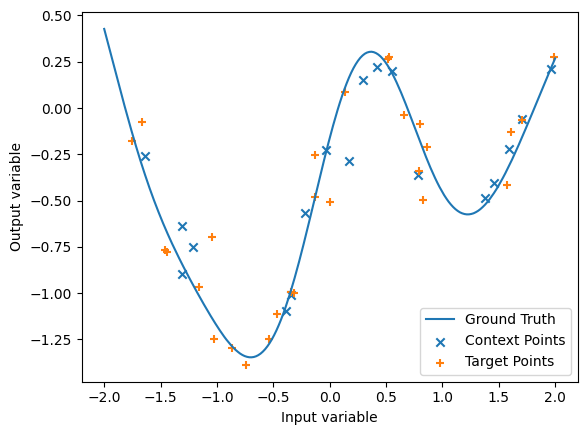

In [4]:
tasks = [gpdg.generate_task() for i in range(num_tasks)]
task = tasks[-1]
plt.plot(task['x'], task['y'], label='Ground Truth')
plt.scatter(task['x_context'], task['y_context'], label='Context Points', marker='x')
plt.scatter(task['x_target'], task['y_target'], label='Target Points', marker='+')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

In [5]:
amort_bnn_model = amort_bnn.AmortNetwork(
    1,
    [50, 50],
    1,
)

opt = torch.optim.Adam(amort_bnn_model.parameters(), lr=1e-2)

In [6]:
loss_evo = []
ll_evo = []
kl_evo = []

epoch_iter = tqdm.tqdm(range(1000), "Epoch")
for i, epoch in enumerate(epoch_iter):
    
    task = tasks[i%num_tasks]
    
    opt.zero_grad()

    loss, ll, kl, noise = amort_bnn_model.elbo_loss(
        task['x_context'].unsqueeze(1), task['y_context'].unsqueeze(1), num_samples=1
    )
    loss_evo.append(loss.item())
    ll_evo.append(ll.item())
    kl_evo.append(kl.item())

    loss.backward()
    opt.step()
    
    epoch_iter.set_postfix({"loss": loss, "ll": ll, "kl": kl})

Epoch: 100%|██████████| 1000/1000 [00:34<00:00, 28.59it/s, loss=tensor(18.8795, grad_fn=<NegBackward0>), ll=tensor(15.6944, grad_fn=<MeanBackward0>), kl=tensor(34.5739, grad_fn=<MeanBackward0>)] 


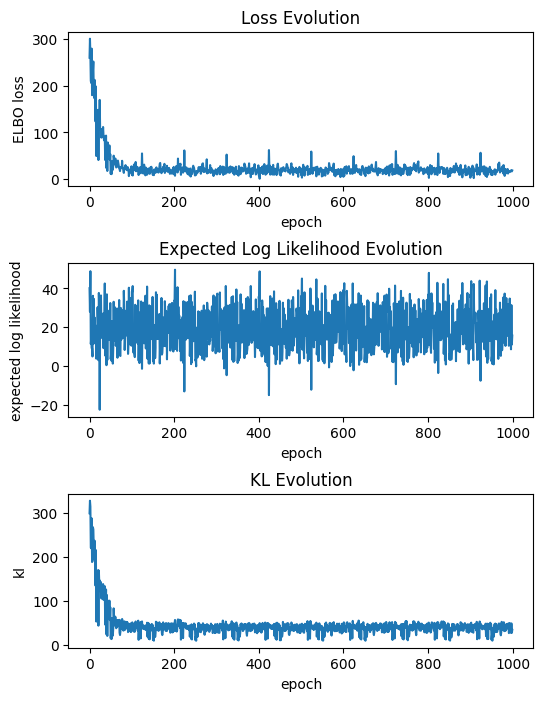

In [7]:
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(6, 8)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(loss_evo)
axs[0].set_ylabel("ELBO loss")
axs[0].set_xlabel("epoch")
axs[0].set_title("Loss Evolution")

axs[1].plot(ll_evo)
axs[1].set_ylabel("expected log likelihood")
axs[1].set_xlabel("epoch")
axs[1].set_title("Expected Log Likelihood Evolution")

axs[2].plot(kl_evo)
axs[2].set_ylabel("kl")
axs[2].set_xlabel("epoch")
axs[2].set_title("KL Evolution")

plt.show()

In [12]:
xs = torch.linspace(-2.5, 2.5, 100).unsqueeze(1)
test_task = gpdg.generate_task()
prediction_samps = amort_bnn_model(test_task['x_context'].unsqueeze(1), test_task['y_context'].unsqueeze(1), x_test=xs, num_samples=100)[1].squeeze(-1).T

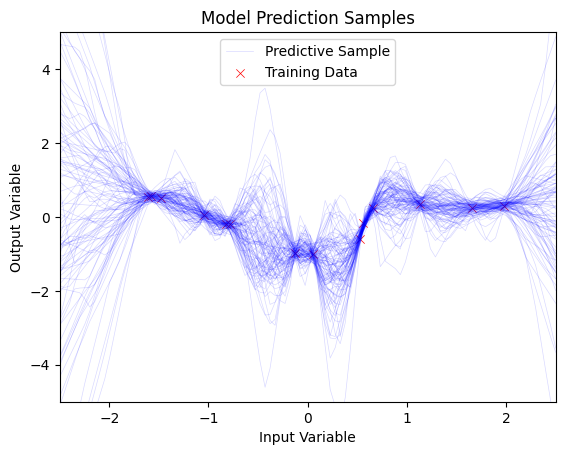

In [14]:
plt.plot(
    xs,
    prediction_samps.detach().numpy()[:, :-1],
    color="blue",
    linewidth=0.5,
    alpha=0.15,
)
plt.plot(
    xs,
    prediction_samps.detach().numpy()[:, -1],
    color="blue",
    linewidth=0.5,
    alpha=0.15,
    label="Predictive Sample",
)
plt.title("Model Prediction Samples")
plt.xlabel("Input Variable")
plt.ylabel("Output Variable")
plt.scatter(test_task['x_context'], test_task['y_context'], marker="x", label="Training Data", color='red', linewidth=0.5)
    
plt.legend()
plt.ylim(-5.0, 5.0)
plt.xlim(-2.5, 2.5)
plt.show()